In [1]:
from google.colab import files

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rahulgoel2001","key":"9e29e945e3b5751e8ca33ac9a3f2e0b0"}'}

In [3]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c digit-recognizer

 82% 5.00M/6.09M [00:00<00:00, 21.9MB/s]
100% 6.09M/6.09M [00:00<00:00, 24.1MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 79.2MB/s]
 55% 5.00M/9.16M [00:00<00:00, 21.9MB/s]
100% 9.16M/9.16M [00:00<00:00, 30.5MB/s]


In [5]:
!7z x train.csv.zip
!7z x test.csv.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 9606023 bytes (9381 KiB)

Extracting archive: train.csv.zip
--
Path = train.csv.zip
Type = zip
Physical Size = 9606023

  0%     45% - train.csv                 90% - train.csv                Everything is Ok

Size:       76775041
Compressed: 9606023

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 6385593 bytes (6236 KiB)

Extracting archive: test.csv.zip
--
Path = test.csv.zip
Type = zip
Physical Size = 6385593

  0% 

In [6]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageEnhance

In [14]:
class MNISTDataset(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        df = pd.read_csv(csv_path)
    
        self.X = np.asarray(df.iloc[:, 1:]).reshape((-1, 28, 28))
        self.X = np.asarray(self.X, dtype = np.float32)
        self.transform = transforms.Compose([transforms.ToPILImage(mode = "F"),
                                             transforms.RandomAffine(degrees = (-20, 20),translate=(0.0, 0.2)),
                                             transforms.ToTensor(), transforms.Normalize(mean = 33.0242, std = 76.6325)])

        self.y = torch.from_numpy(df.iloc[:, 0].values).long()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.transform(self.X[idx]), self.y[idx]

In [13]:
# First ran this without normalizing to find the mean and the std. And then normalized using that.
mean = 0.
std = 0.
cnt = 0.

for d in data:
    mean += d[0].mean()
    std += d[0].std()
    cnt += 1

mean /= cnt
std /= cnt
print(mean, std)

tensor(33.0345) tensor(76.6419)


In [15]:
data = MNISTDataset("train.csv")

The number is 5


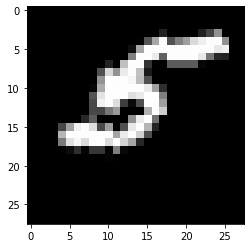

In [16]:
plt.imshow(data[1007][0].view(28, 28), cmap = "gray")
print(f"The number is {data[1007][1]}")

In [41]:
def make_dataloader(dataset, pct):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    np.random.shuffle(indices)
    split = int(np.floor(dataset_size) * pct)
    train_indices, valid_indices = indices[split:], indices[:split]
    train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_indices)

    train_loader = DataLoader(dataset, batch_size = 128, sampler = train_sampler)
    valid_loader = DataLoader(dataset, batch_size = 128, sampler = valid_sampler)

    return train_loader, valid_loader

In [42]:
train_loader, valid_loader = make_dataloader(data, 0.2)

In [76]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, stride = 1).cuda()
        self.relu1 = nn.ReLU().cuda()
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride = 1).cuda()

        self.cnn2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, stride = 1).cuda()
        self.relu2 = nn.ReLU().cuda()
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride = 1).cuda()

        self.cnn3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1).cuda()
        self.relu3 = nn.ReLU().cuda()
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride = 1).cuda()

        self.cnn4 = nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1).cuda()
        self.relu4 = nn.ReLU().cuda()
        self.pool4 = nn.MaxPool2d(kernel_size = 2, stride = 1).cuda()

        self.fc5 = nn.Linear(16384, 1000).cuda()
        self.relu5 = nn.ReLU().cuda()
        self.fc6 = nn.Linear(1000, 100).cuda()
        self.relu6 = nn.ReLU().cuda()
        self.fc7 = nn.Linear(100, 10).cuda()

    def forward(self, x):
        x = self.cnn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.cnn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.cnn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = self.cnn4(x)
        x = self.relu4(x)
        x = self.pool4(x)

        x = x.view(x.size(0), -1)
        x = self.fc5(x)
        x = self.relu5(x)
        x = self.fc6(x)
        x = self.relu6(x)
        x = self.fc7(x)
        return x

In [77]:
model = Network()
model.cuda()

Network(
  (cnn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (pool4): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc5): Linear(in_features=16384, out_features=1000, bias=True)
  (relu5): ReLU()
  (fc6): Linear(in_features=1000, out_features=100, bias=True)
  (relu6): ReLU()
  (fc7): Linear(in_features=100, out_features=10, bias=True)
)

In [86]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 1e-7, momentum = 0.9)

In [82]:
loss_log = []
accuracy_log = []
val_accuracy_log = []
val_loss_log = []

In [80]:
use_cuda = True
use_cuda, torch.cuda.is_available()

(True, True)

In [81]:
def accuracy(outputs, y):
    _, preds = torch.max(outputs, dim = 1)
    return torch.tensor(torch.sum(preds == y).item() / len(preds))

In [88]:
epochs = 1
for e in range(epochs):
    trainacc = torch.tensor(0, dtype = torch.float32)
    trainloss = torch.tensor(0, dtype = torch.float32)
    traincnt =  torch.tensor(0, dtype = torch.float32)

    model.train()
    for (i, batch) in enumerate(train_loader):
        traincnt += 1
        # Take out batch from dataloader
        X, y = batch
        X, y = Variable(X), Variable(y)
        if use_cuda and torch.cuda.is_available():
            X = X.cuda()
            y = y.cuda()

        # do the forward pass
        output = model(X)

        # calculate the loss and the gradients wrt the loss
        loss = loss_func(output, y)
        optimizer.zero_grad()
        loss.backward()

        # do the backward pass
        optimizer.step()
        
        # store the history
        acc = accuracy(output, y)
        trainloss += loss
        trainacc += acc
    
    trainloss = trainloss / traincnt
    trainacc = trainacc / traincnt
    loss_log.append(trainloss)
    accuracy_log.append(trainacc)
    
    model.eval()
    with torch.no_grad():
        totloss = torch.tensor(0, dtype= torch.float32)
        totacc = torch.tensor(0, dtype = torch.float32)
        cnt = torch.tensor(0, dtype = torch.float32)
        for batch in valid_loader:
            cnt += 1
            X, y = batch
            if use_cuda and torch.cuda.is_available():
                X = X.cuda()
                y = y.cuda()
            output = model(X)
            loss = loss_func(output, y)
            totloss += loss
            totacc += accuracy(output, y)
        totloss = totloss / cnt
        totacc = totacc / cnt
        val_loss_log.append(totloss)
        val_accuracy_log.append(totacc)
        print(f"Validation Loss {totloss} Validation Accuracy {totacc} Train Loss {trainloss} Train Accuracy {trainacc}")

Validation Loss 0.13228222727775574 Validation Accuracy 0.9579545259475708 Train Loss 0.13052308559417725 Train Accuracy 0.957996666431427


so now this is our final model. but we dont want to waste data. so merge validation and test and train on it.

In [94]:
train_loader, valid_loader = make_dataloader(data, 0.0)

In [99]:
model = Network()

In [104]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 5e-8, momentum = 0.9)

In [105]:
epochs = 10
for e in range(epochs):
    trainacc = torch.tensor(0, dtype = torch.float32)
    trainloss = torch.tensor(0, dtype = torch.float32)
    traincnt =  torch.tensor(0, dtype = torch.float32)

    model.train()
    for (i, batch) in enumerate(train_loader):
        traincnt += 1
        # Take out batch from dataloader
        X, y = batch
        X, y = Variable(X), Variable(y)
        if use_cuda and torch.cuda.is_available():
            X = X.cuda()
            y = y.cuda()

        # do the forward pass
        output = model(X)

        # calculate the loss and the gradients wrt the loss
        loss = loss_func(output, y)
        optimizer.zero_grad()
        loss.backward()

        # do the backward pass
        optimizer.step()
        
        # store the history
        acc = accuracy(output, y)
        trainloss += loss
        trainacc += acc
    
    trainloss = trainloss / traincnt
    trainacc = trainacc / traincnt

    print(f"Train Loss {trainloss} Train Accuracy {trainacc}")

Train Loss 0.1730477660894394 Train Accuracy 0.9441251754760742
Train Loss 0.16501842439174652 Train Accuracy 0.9476396441459656
Train Loss 0.16553950309753418 Train Accuracy 0.9468560218811035
Train Loss 0.16345557570457458 Train Accuracy 0.9476871490478516
Train Loss 0.16648449003696442 Train Accuracy 0.947378396987915
Train Loss 0.16546481847763062 Train Accuracy 0.9465235471725464
Train Loss 0.1629662960767746 Train Accuracy 0.9476396441459656
Train Loss 0.16248637437820435 Train Accuracy 0.948352038860321
Train Loss 0.16489355266094208 Train Accuracy 0.9462385773658752
Train Loss 0.16278362274169922 Train Accuracy 0.9478058218955994


In [106]:
class MNISTTestDataset(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        df = pd.read_csv(csv_path)
    
        self.X = np.asarray(df.iloc[:, :]).reshape((-1, 28, 28))
        self.X = np.asarray(self.X, dtype = np.float32)
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = 33.0242, std = 76.6325)])

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.transform(self.X[idx])

In [107]:
test_data = MNISTTestDataset("test.csv")

In [111]:
testloader = DataLoader(test_data, batch_size = 128)

In [119]:
predictions = []

In [120]:
for (i, X) in enumerate(testloader):
    if use_cuda and torch.cuda.is_available():
        X = X.cuda()
    with torch.no_grad():
        output = model(X)
        _, preds = torch.max(output, dim = 1)
        for prediction in preds:
            predictions.append(prediction.item())

In [123]:
idx = [i + 1 for i in range(len(predictions))]

In [124]:
df_submission = pd.DataFrame({"ImageId" : idx, "Label" : predictions})

In [129]:
df_submission.to_csv("submission.csv", index = False)

In [130]:
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>